# P2 Advanced Lane Finding - single image

In this section, I will give a test on test images.
## The order may be:
### 1.Camera calibration;
### 2.Perspective transformation;
### 3.Mark the lane lines and calculate the curvature;

## Here are codes below: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
from pylab import *
%matplotlib inline
%matplotlib qt

### 1.Camera calibration
In this section, I will calibrate the camera by processing iamges in the *camera_cal* folder.
#### 1.1. import the calibration images in folder *camera_cal*, which is used for camera calibration;
#### 1.2. create arrays to store the object points and image points from all the images;

In [2]:
calibration_images_input = glob.glob('camera_cal/calibration*.jpg')

# arrays to store the object points and image points from all the images
image_points = []  # 2D points in image plane
object_points = [] # 3D points in real world space (fake)

# create object points 
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)  # generate the coordinates of x and y

#### 1.3. obtain undistorted images by using findChessboardCorners(), calibrateCamera() and undistort() ;

In [3]:
for fname in calibration_images_input:    # read in each image
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    # convert image to grayscale
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # if the corners are found, add object points, image points
    if ret == True:
        image_points.append(corners)
        object_points.append(objp)
# calibrating the camera
ret, mtx, dist, rvecs, tvecs = \
cv2.calibrateCamera(object_points, image_points, gray.shape[::-1],None,None)
# undistort the image
undist = cv2.undistort(img,mtx,dist,None,mtx)

#### 1.4. visualize the processed iamge;

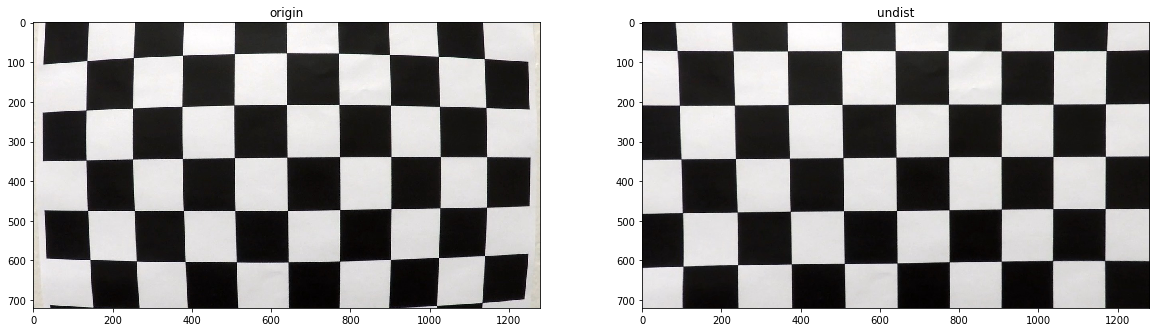

In [4]:
# Visualize all these images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('origin')
ax1.imshow(img)
ax2.set_title('undist')
ax2.imshow(undist)

### 2.Perspective transformation
In this section, I will calibrate the test images, and give them perspective transformation.
#### 2.1. get undistort test images;

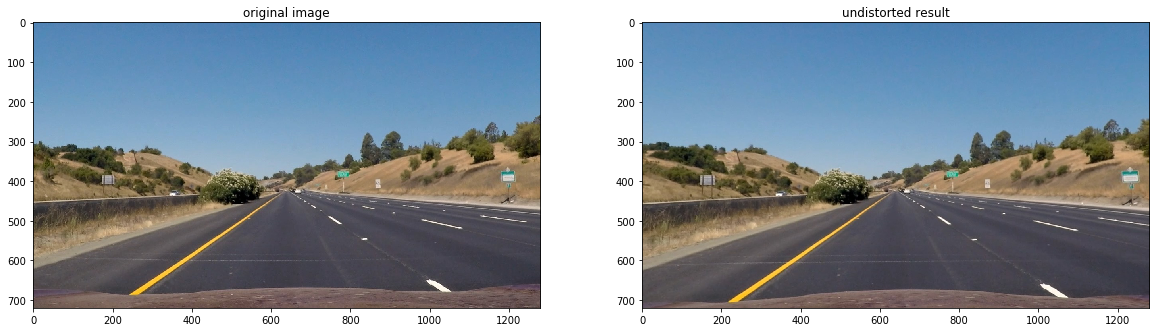

In [18]:
original_image = mpimg.imread('test_images/straight_lines1.jpg')
# original_image = mpimg.imread('test_images/test6.jpg')
# original_image = mpimg.imread('project_video.mp4_20180726_092836.538.jpg')

original_gray = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
# image calibration
ret, mtx, dist, rvecs, tvecs = \
cv2.calibrateCamera(object_points, image_points, original_gray.shape[::-1],None,None)

# undistort the image
undistort_image = cv2.undistort(original_image,mtx,dist,None,mtx)

# Visualize both images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('original image')
ax1.imshow(original_image)
ax2.set_title('undistorted result')
ax2.imshow(undistort_image)

#### 2.2. perform a perspective transform;
Now the image is undistorted, then perform a perspective transform.

In [6]:
# write some functions
def gray(img):
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
def undistort(img):
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

Adjust the src matrix manually to get the unwarped image which shows roughly parallel roads under the condition of test images.

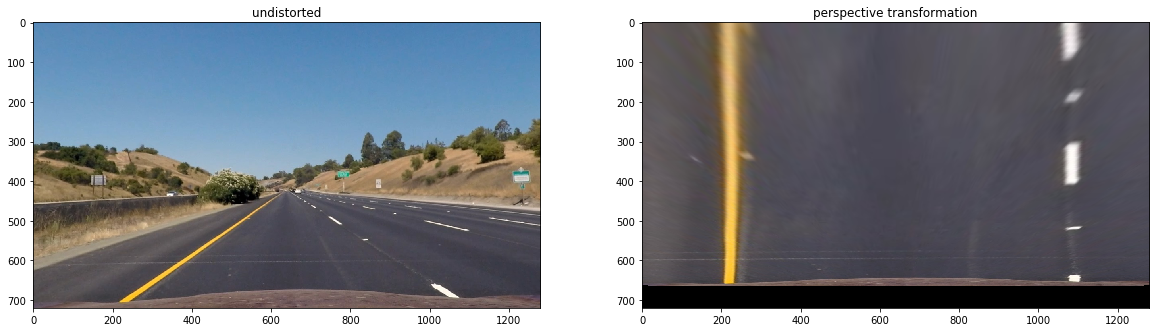

In [19]:
# perspective transform
gray_undistort_image = gray(undistort_image)

# # for testing
# img_out_test = binaryx(test_gray)

offset = 100
img_size = (gray_undistort_image.shape[1], gray_undistort_image.shape[0])
src = np.float32([[img_size[0]*0.43,img_size[1]*0.65],
                  [img_size[0]*0.57,img_size[1]*0.65],
                  [img_size[0]*0.19,img_size[1]*0.88],
                  [img_size[0]*0.81,img_size[1]*0.88]])
dst = np.float32([[offset,offset],
                  [img_size[0]-offset, offset],
                  [offset,img_size[1]-offset],
                  [img_size[0]-offset,img_size[1]-offset]])
M = cv2.getPerspectiveTransform(src, dst)
unwarped = cv2.warpPerspective(undistort_image, M, img_size, flags=cv2.INTER_LINEAR)

# Visualize these images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('undistorted')
ax1.imshow(undistort_image)
ax2.set_title('perspective transformation')
ax2.imshow(unwarped)

### 3.Mark the lane lines and calculate the curvature
#### 3.1. pre-process the unwarped image

In [20]:
# adding some other conditions
def canny(img, low_threshold, high_threshold):
    return cv2.canny(img, low_threshold, high_threshold)
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size,kernel_size), 0)
# sobel test
def sobelx(gray):
    return cv2.Sobel(gray, cv2.CV_64F, 1, 0)
def sobely(gray):
    return cv2.Sobel(gray, cv2.CV_64F, 0, 1)
def absolutexy(gray):
    return np.sqrt( (np.absolute(sobelx(gray)))**2 + (np.absolute(sobely(gray)))**2 )
def scaled_sobelx(gray):
    return np.uint8(255*np.absolute(sobelx(gray))/np.max(np.absolute(sobelx(gray))))
def scaled_sobely(gray):
    return np.uint8(255*np.absolute(sobely(gray))/np.max(np.absolute(sobely(gray))))
def scaled_sobelxy(gray):
    return np.uint8(255*absolutexy(gray)/np.max(absolutexy(gray)))
# binary output
def binaryx(gray, low=20 , high=150):
    binary = np.zeros_like(gray)
    binary[(scaled_sobelx(gray) >= low) & (scaled_sobelx(gray) <= high)] = 1
    return binary
def binaryy(gray, low=20 , high=150):
    binary = np.zeros_like(gray)
    binary[(scaled_sobely(gray) >= low) & (scaled_sobely(gray) <= high)] = 1
    return binary
def binaryxy(gray, low=20 , high=150):
    binary = np.zeros_like(gray)
    binary[(scaled_sobelxy(gray) >= low) & (scaled_sobelxy(gray) <= high)] = 1
    return binary
def threshold(gray, low=50, high=150):
    binary = np.zeros_like(gray)
    binary[(gray > low) & (gray < high)] = 1
    return binary
def RGB(image):
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    return R,G,B
def HLS(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    return H,L,S

Visualize these test images:

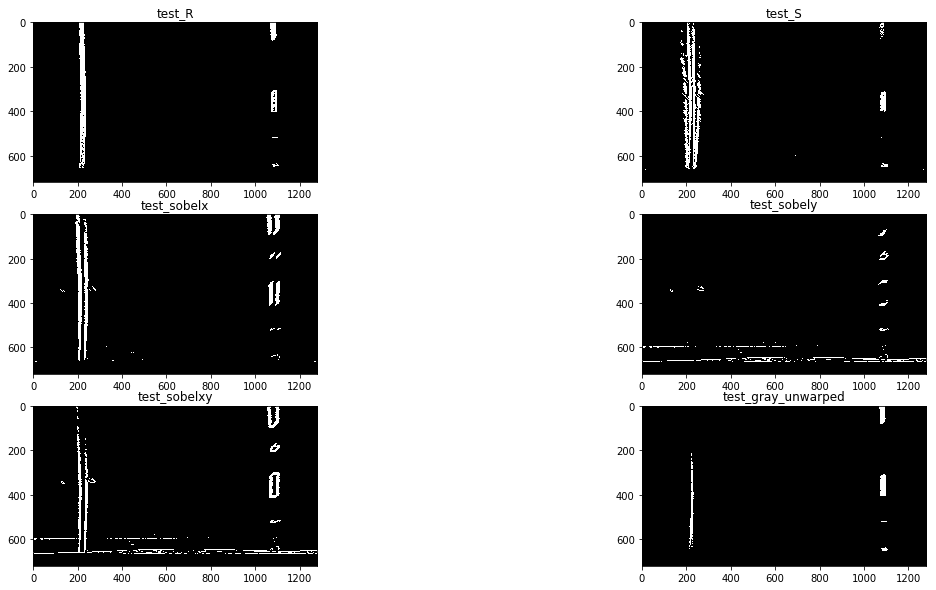

In [21]:
image_testfolder = np.copy(unwarped) # RGB
gray_unwarped = gray(unwarped) # gray
R,G,B = RGB(image_testfolder)
H,L,S = HLS(image_testfolder)

test_gray_unwarped =  gaussian_blur(gray_unwarped, 3)

# times = 5
# kernel = np.ones((times,times), np.uint8)
# erroding = cv2.erode(original_image, kernel)

test_R = threshold(R,200,255) # good
test_S = binaryx(S,10,150) # good
test_sobelx = binaryx(test_gray_unwarped)
test_sobely = binaryy(test_gray_unwarped)
test_sobelxy = binaryxy(test_gray_unwarped)
test_gray_unwarped = threshold(gray_unwarped,200,255)

# Visualize these images
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,10))
ax1.set_title('test_R')
ax1.imshow(test_R,cmap='gray')
ax2.set_title('test_S')
ax2.imshow(test_S,cmap='gray')
ax3.set_title('test_sobelx')
ax3.imshow(test_sobelx,cmap='gray')
ax4.set_title('test_sobely')
ax4.imshow(test_sobely,cmap='gray')
ax5.set_title('test_sobelxy')
ax5.imshow(test_sobelxy,cmap='gray')
ax6.set_title('test_gray_unwarped')
ax6.imshow(test_gray_unwarped,cmap='gray')

Test on combined image;

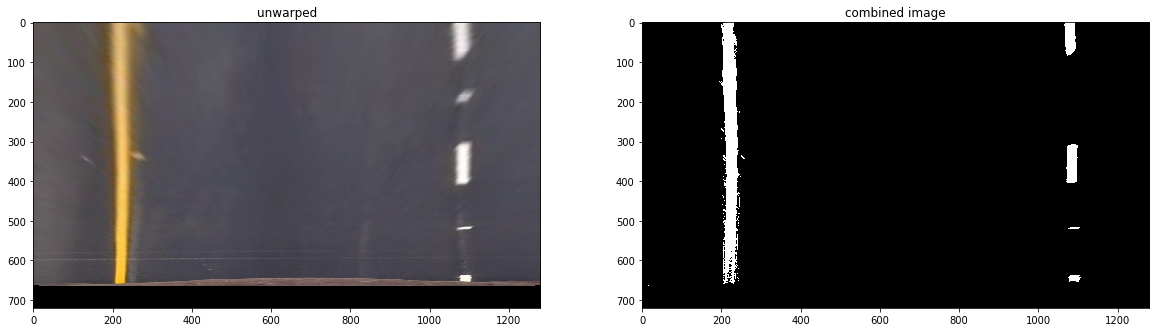

In [22]:
# combined iamge
combined = np.zeros_like(test_gray_unwarped)
combined[ \
        (test_gray_unwarped == 1) \
         | (test_R == 1) \
         | (test_S == 1) \
         & (test_sobelx == 1) \
        ] = 1         # modified on 2018/8/4 pm

# Visualize these images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('unwarped')
ax1.imshow(unwarped)
ax2.set_title('combined image')
ax2.imshow(combined,cmap='gray')

#### 3.2. get polynomial fit parameters through histogram peaks
Get leftbase and rightbase points.

leftx_base: 229 rightx_base: 1080
corrsponding conversion: 3.7(m) / 851 pixels
1280 640
left distance: 411 right distance: 440
The vehicle is 14 (m) right of center


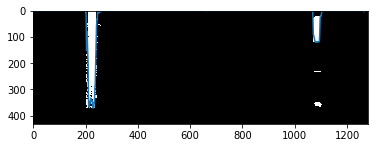

In [23]:
# polynomial fit: histogram peaks
# normalize the image(0~255) back to 0~1, show the histogram
# testpolyfit = test_gray_unwarped/255 
def hist(img):
    bottom_half = np.copy(img)[int(img.shape[0]/5*2):,:]
    plt.imshow(bottom_half,cmap='gray')
    histogram = np.sum(bottom_half,axis=0)
    return histogram
histogram = hist(combined)
plt.plot(histogram)

# output the leftbase and rightbase point
midpoint = np.int(histogram.shape[0]/5*2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print('leftx_base:', leftx_base, 'rightx_base:', rightx_base)
print("corrsponding conversion:", "3.7(m) /",np.abs(leftx_base-rightx_base),"pixels")
middle_point = combined.shape[1]//2
print(combined.shape[1], middle_point)
dist_left = middle_point - leftx_base
dist_right = rightx_base - middle_point
print("left distance:",dist_left, "right distance:",dist_right)
diff = (dist_right - dist_left) // 2
if diff>0:
    print("The vehicle is",diff,"(m) right of center") 
else:
    print("The vehicle is",-diff,"(m) left of center") 

In [24]:
# copied from Finding the Lines:Sliding Window
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//5*2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # plt.imshow(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//5*2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # print(len(nonzeroy), nonzeroy, len(nonzerox), nonzerox)
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
#         # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # print(len(good_left_inds),good_left_inds, len(good_right_inds), good_right_inds)
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        # print(len(left_lane_inds),left_lane_inds, len(right_lane_inds), right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`  meter
    left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    # Fit a second order polynomial to each using `np.polyfit` pixel
    left_fit_pixel = np.polyfit(lefty, leftx, 2)
    right_fit_pixel = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*(ploty * ym_per_pix)**2 + left_fit[1]*ploty * ym_per_pix + left_fit[2]
        right_fitx = right_fit[0]*(ploty * ym_per_pix)**2 + right_fit[1]*ploty * ym_per_pix + right_fit[2]
        left_fitx_pixel = left_fit_pixel[0]*ploty**2 + left_fit_pixel[1]*ploty + left_fit_pixel[2]
        right_fitx_pixel = right_fit_pixel[0]*ploty**2 + right_fit_pixel[1]*ploty + right_fit_pixel[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*(ploty * ym_per_pix)**2 + 1*ploty * ym_per_pix
        right_fitx = 1*(ploty * ym_per_pix)**2 + 1*ploty * ym_per_pix
        left_fitx_pixel = 1*ploty**2 + 1*ploty
        right_fitx_pixel = 1*ploty**2 + 1*ploty
    
    # calculate curvature
    y_eval = np.max(ploty)

    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx_pixel, ploty, color='yellow')
    plt.plot(right_fitx_pixel, ploty, color='yellow')

    return out_img, left_curverad, right_curverad, left_fitx, right_fitx, ploty, left_fitx_pixel, right_fitx_pixel

Show polynomial fit parameters and curvature:

left_curvature: 2659.29515453 
right_curvature: 15808.4937734


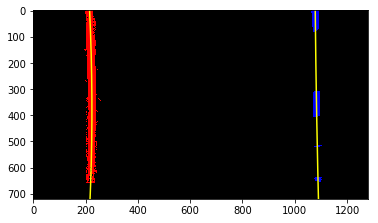

In [25]:
out_img, left_curverad, right_curverad, left_fitx, right_fitx, ploty, left_fitx_pixel, right_fitx_pixel \
= fit_polynomial(combined)
plt.imshow(out_img)
print('left_curvature:', left_curverad, '\nright_curvature:', right_curverad)

#### 3.3. mark the lane lines and show text on the screen

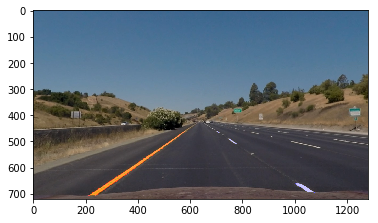

In [26]:
# mark the lane lines
Minv = np.linalg.inv(M)
rev_out_img = cv2.warpPerspective(out_img, Minv, (undistort_image.shape[1], undistort_image.shape[0])) 
test_addWeighted = cv2.addWeighted(rev_out_img, 0.8, undistort_image, 0.8, 0.)
plt.imshow(test_addWeighted)

1280 640
left distance: 411 right distance: 440


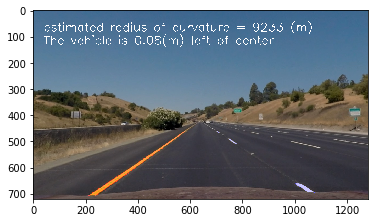

In [27]:
# show text on the screen
font=cv2.FONT_HERSHEY_SIMPLEX # using default fonts
im = np.copy(test_addWeighted)
estimated_curvature = int( (left_curverad + right_curverad)/2 )
# estimated_curvature = int( np.sqrt(left_curverad * right_curverad) )
outputStr = 'estimated radius of curvature = '+ str(estimated_curvature) + ' (m)'

im=cv2.putText(im,outputStr,(40,80),font,1.5,(255,255,255),2)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension 
middle_point = combined.shape[1]//2
print(combined.shape[1], middle_point)
dist_left = middle_point - leftx_base
dist_right = rightx_base - middle_point
print("left distance:",dist_left, "right distance:",dist_right)
diff = (dist_right - dist_left) / 2 * xm_per_pix

if diff>0:
    diff = "%.2f" % diff
    out_str = "The vehicle is " + diff + "(m) left of center"
    im=cv2.putText(im,out_str,(40,130),font,1.5,(255,255,255),2)
else:
    diff = "%.2f" % -diff
    out_str = "The vehicle is " + diff + "(m) right of center"
    im=cv2.putText(im,out_str,(40,130),font,1.5,(255,255,255),2)    
    
plt.imshow(im)

#### 3.4. show the mark area on the screen

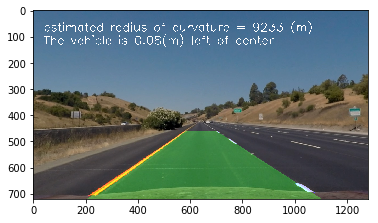

In [28]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(gray_unwarped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension 

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx_pixel, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx_pixel, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = np.linalg.inv(M)
newwarp = cv2.warpPerspective(color_warp, Minv, (undistort_image.shape[1], undistort_image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(im, 1, newwarp, 0.3, 0)
plt.imshow(result)

So far so good on the simple pictures. Let's test on the videos.

In [17]:
cv2.imwrite('output_images/result.jpg',cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

True